# Seq2Seq——序列到序列

机器翻译
- 给定一个源语言的句子，自动翻译成目标语言
- 这两个句子可以有不同的长度

Seq2Seq
- 编码器是一个RNN，读取输入句子
  - 可以是双向
- 解码器使用另外一个RNN来执行输出

编码器-解码器细节
- 编码器是没有输出的RNN
- 编码器最后时间步的隐状态用作解码器的初始隐状态
  
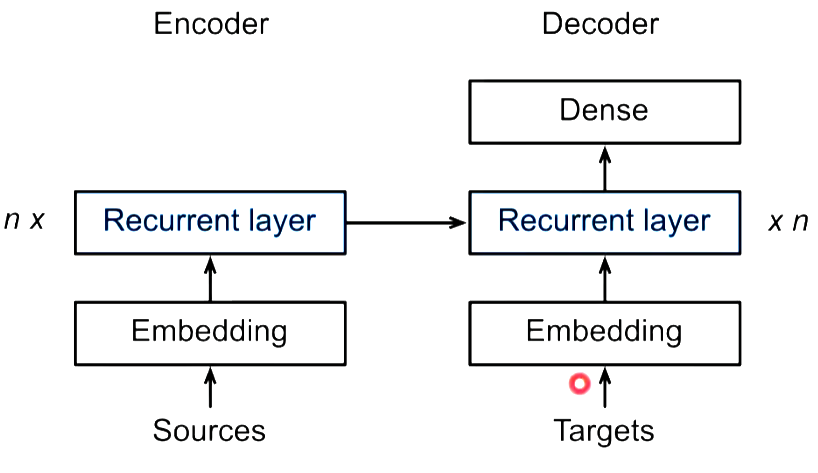

训练
- 训练时解码器使用目标句子作为输入

衡量生成序列的好坏的BLEU

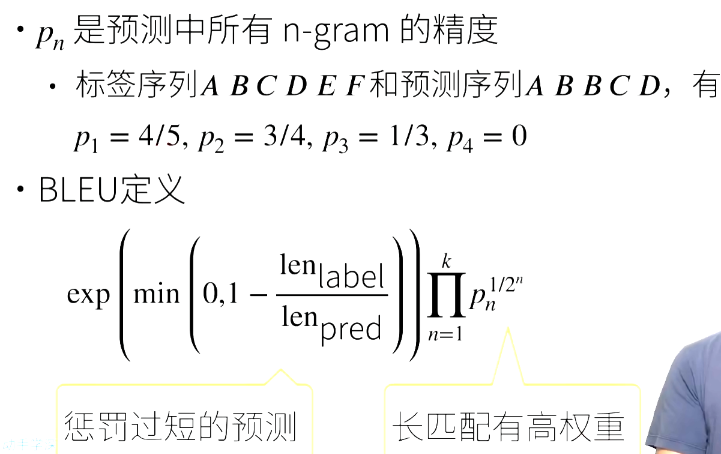

总结
- Seq2Seq从一个句子生成另一个句子
- 编码器和解码器都是RNN
- 将编码器最后时间隐状态来初始化解码器隐状态来完成信息传递
- 常用BLEU来衡量生成序列的好坏

In [1]:
import collections, math, torch
from torch import nn
from d2l import torch as d2l

In [2]:
#编码器实现
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络的编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout= 0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        #嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        #GRU模型
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout= dropout)

    def forward(self, X, *args):
        #X的形状(batch_size, num_steps, num_hiddens)
        X = self.embedding(X)
        #第一个轴对应时间步
        X = X.permute(1, 0, 2)
        #output的形状(num_steps, batch_size, num_hiddens)
        #state的形状(num_layers, batch_size, num_hiddens)
        output, state = self.rnn(X)
        return output, state

In [3]:
#测试编码器结构
encoder = Seq2SeqEncoder(vocab_size= 10, embed_size= 8, num_hiddens= 16, 
                         num_layers= 2)
#模型设置为验证状态，弃用dropout
encoder.eval()
X = torch.zeros((4, 7), dtype= torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [4]:
#解码器实现
#@save
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器的实现"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout= 0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers)
        #输出层使用全连接层
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_inputs, *args):
        return enc_inputs[1]
    
    def forward(self, X, state):
        #X的形状(batch_size, num_steps, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        #广播context：使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        #output形状：(batch_size, num_steps, vocab_size)
        #state形状：(num_layers, batch_size, num_hiddens)
        return output, state

In [5]:
decoder = Seq2SeqDecoder(vocab_size= 10, embed_size= 8, num_hiddens= 16, num_layers= 2)
decoder.eval()
#将编码器的最后状态作为解码器的初始状态
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [6]:
#定义损失函数
#将填充词元的预测排除在损失函数的计算之外
#通过零值化屏蔽不相关的项
def sequence_mask(X, valid_len, value= 0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype= torch.float32, 
                        device= X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [7]:
#另一个测试样例
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value= -1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [8]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    #pred形状(batch_size, num_steps, vocab_size)
    #label形状(batch_size, num_steps)
    #valid_len形状(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        #带有遮蔽的权重计算
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        #计算不加权重的交叉熵损失
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim= 1)
        return weighted_loss

In [9]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype= torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [10]:
#训练模型
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        """依据层类别进行参数初始化"""
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    #添加初始化参数
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr= lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel= 'epoch', ylabel= 'loss', 
                            xlim= [10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) #计算总损失，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']]* Y.shape[0], 
                                device= device).reshape(-1, 1)
            #加入起始符
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            #计算总损失并反向传播
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f}'
          f'tokens/ sec on {str(device)}')

loss 0.018, 21155.4tokens/ sec on cuda:0


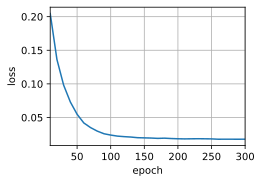

In [11]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab =  d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [12]:
#执行预测
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights= False):
    """序列到序列模型的预测"""
    #执行预测时将模型设置为验证状态
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device= device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    #添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype= torch.long, device= device), dim= 0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    #添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype= torch.long, device= device), dim= 0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        #使用具有预测最高可能性的词元作为解码器预测下一个时间步的输入
        dec_X = Y.argmax(dim= 2)
        pred = dec_X.squeeze(dim= 0).type(torch.int32).item()
        #保持注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        #一旦序列结束词元被执行过预测，即代表完成输出序列
        if pred == tgt_vocab['<eos>']:
            break
        #将预测结果加入输出列表
        output_seq.append(pred)
    #返回输出列表以及注意力权重
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [13]:
#评估预测序列
def bleu(pred_seq, label_seq, k):
    """计算BLEU评分"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1- len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, labels_sub = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            labels_sub[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if labels_sub[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                labels_sub[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [14]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    # print(f"Translation: '{translation}', Length: {len(translation.split())}")
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu <unk> ., bleu 0.658
he's calm . => qu'est-ce qu'on s'est s'est <unk> ., bleu 0.000
i'm home . => je suis malade ., bleu 0.512
